In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

In [105]:
phoneme_audio = "/data/bare_data/01-Evgeniy.wav"
# ipd.Audio(phoneme_audio)

In [106]:
phoneme, sr = torchaudio.load(phoneme_audio)
phoneme = phoneme.cpu()
print(phoneme.shape)

torch.Size([2, 17408])


## Waveform

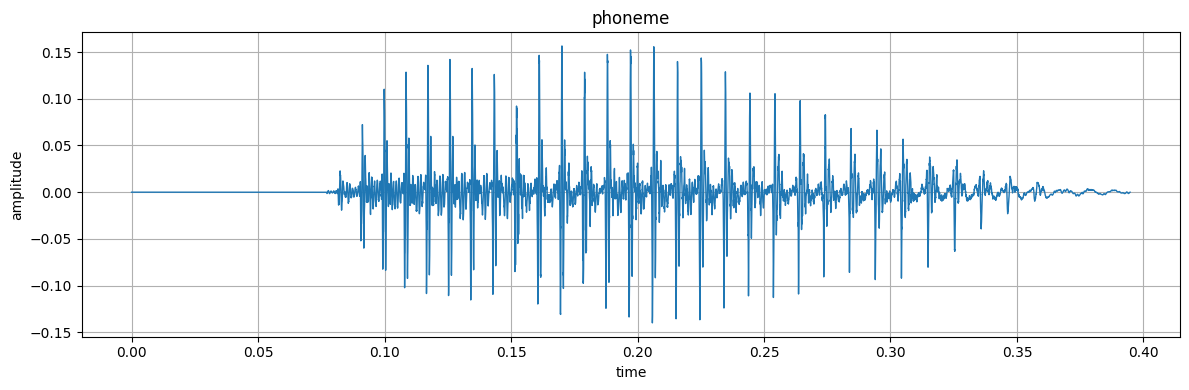

In [107]:
if phoneme.shape[0] > 1:
    phoneme = phoneme.mean(dim=0)

time = torch.arange(0, phoneme.size(0)) / sr

plt.figure(figsize=(12, 4))
plt.plot(time.numpy(), phoneme.numpy(), linewidth=1)
plt.title("phoneme")
plt.xlabel("time")
plt.ylabel("amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## STFT, Spectrogram

In [108]:
n_fft = 2048
hop_length = 512
win_length = None

window = torch.hann_window(n_fft)

stft_result = torch.stft(
    phoneme,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window,
    return_complex=True
)
stft_result.shape

torch.Size([1025, 35])

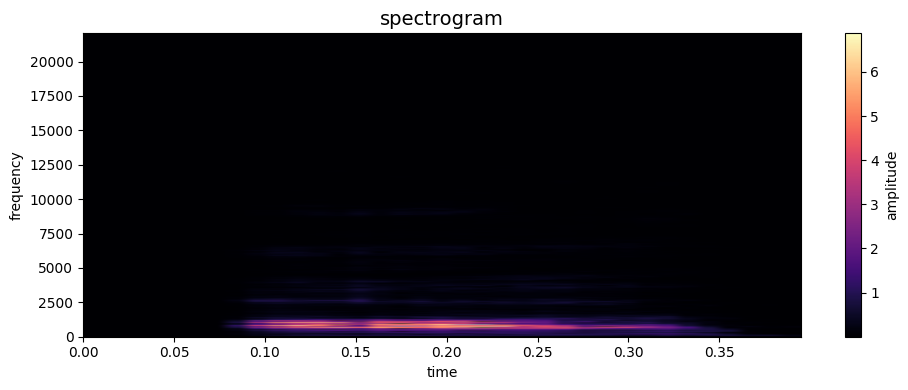

In [109]:
spectrogram = T.Spectrogram(n_fft=1024, hop_length=512, power=1.0)
spec = spectrogram(phoneme)

plt.figure(figsize=(10, 4))
plt.imshow(
    spec.numpy(),
    origin='lower',
    aspect='auto',
    cmap='magma',
    extent=[0, phoneme.size(0)/sr, 0, sr//2]
)

plt.title("spectrogram", fontsize=14)
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(label="amplitude")
plt.tight_layout()
plt.show()


## Log Amplitude Spectrogram

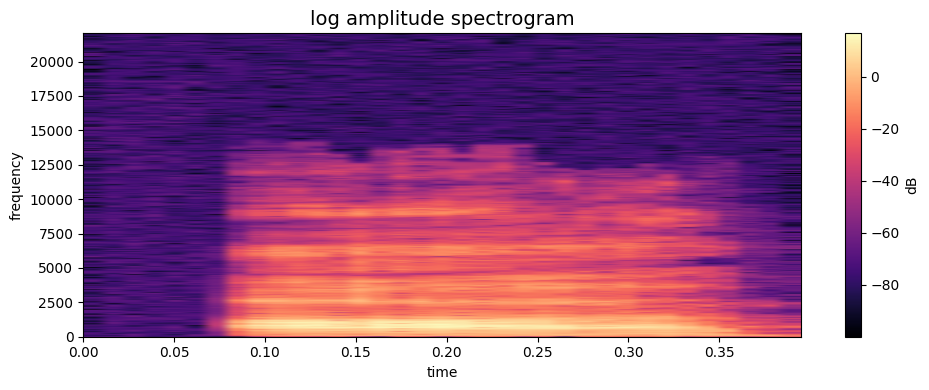

In [110]:
transform = T.Spectrogram(n_fft=1024, hop_length=512, power=2.0)
spec = transform(phoneme)

spec_db = 10 * torch.log10(spec + 1e-10)

plt.figure(figsize=(10, 4))
plt.imshow(spec_db.numpy(),
           origin='lower',
           aspect='auto',
           cmap='magma',
           extent=[0, phoneme.size(0)/sr, 0, sr//2])
plt.title("log amplitude spectrogram", fontsize=14)
plt.xlabel("time")
plt.ylabel("frequency")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()


## Log Frequency Spectrogram

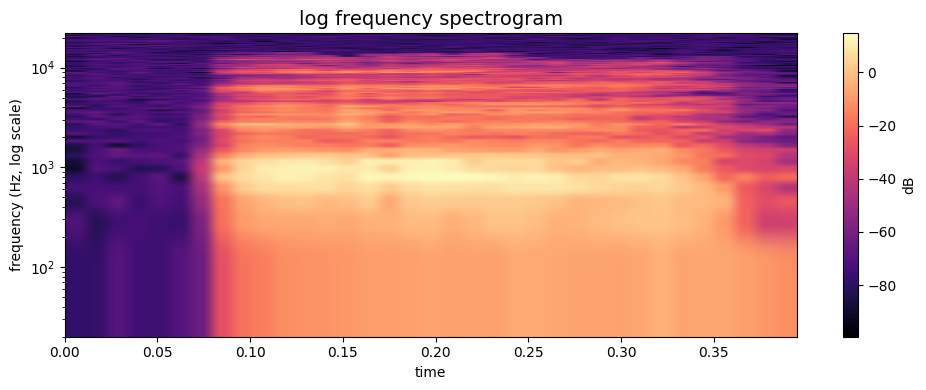

In [111]:
spec_db_4d = spec_db.unsqueeze(0).unsqueeze(0)
log_bins = 128

spec_logfreq = F.interpolate(spec_db_4d, size=(log_bins, spec_db.shape[-1]), mode='bilinear', align_corners=False)
spec_logfreq = spec_logfreq.squeeze()

plt.figure(figsize=(10, 4))
plt.imshow(spec_logfreq.numpy(),
           origin='lower',
           aspect='auto',
           cmap='magma',
           extent=[0, phoneme.size(0)/sr, 20, sr//2])
plt.yscale("log")
plt.title("log frequency spectrogram", fontsize=14)
plt.xlabel("time")
plt.ylabel("frequency (Hz, log scale)")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()


## Mel filter bank

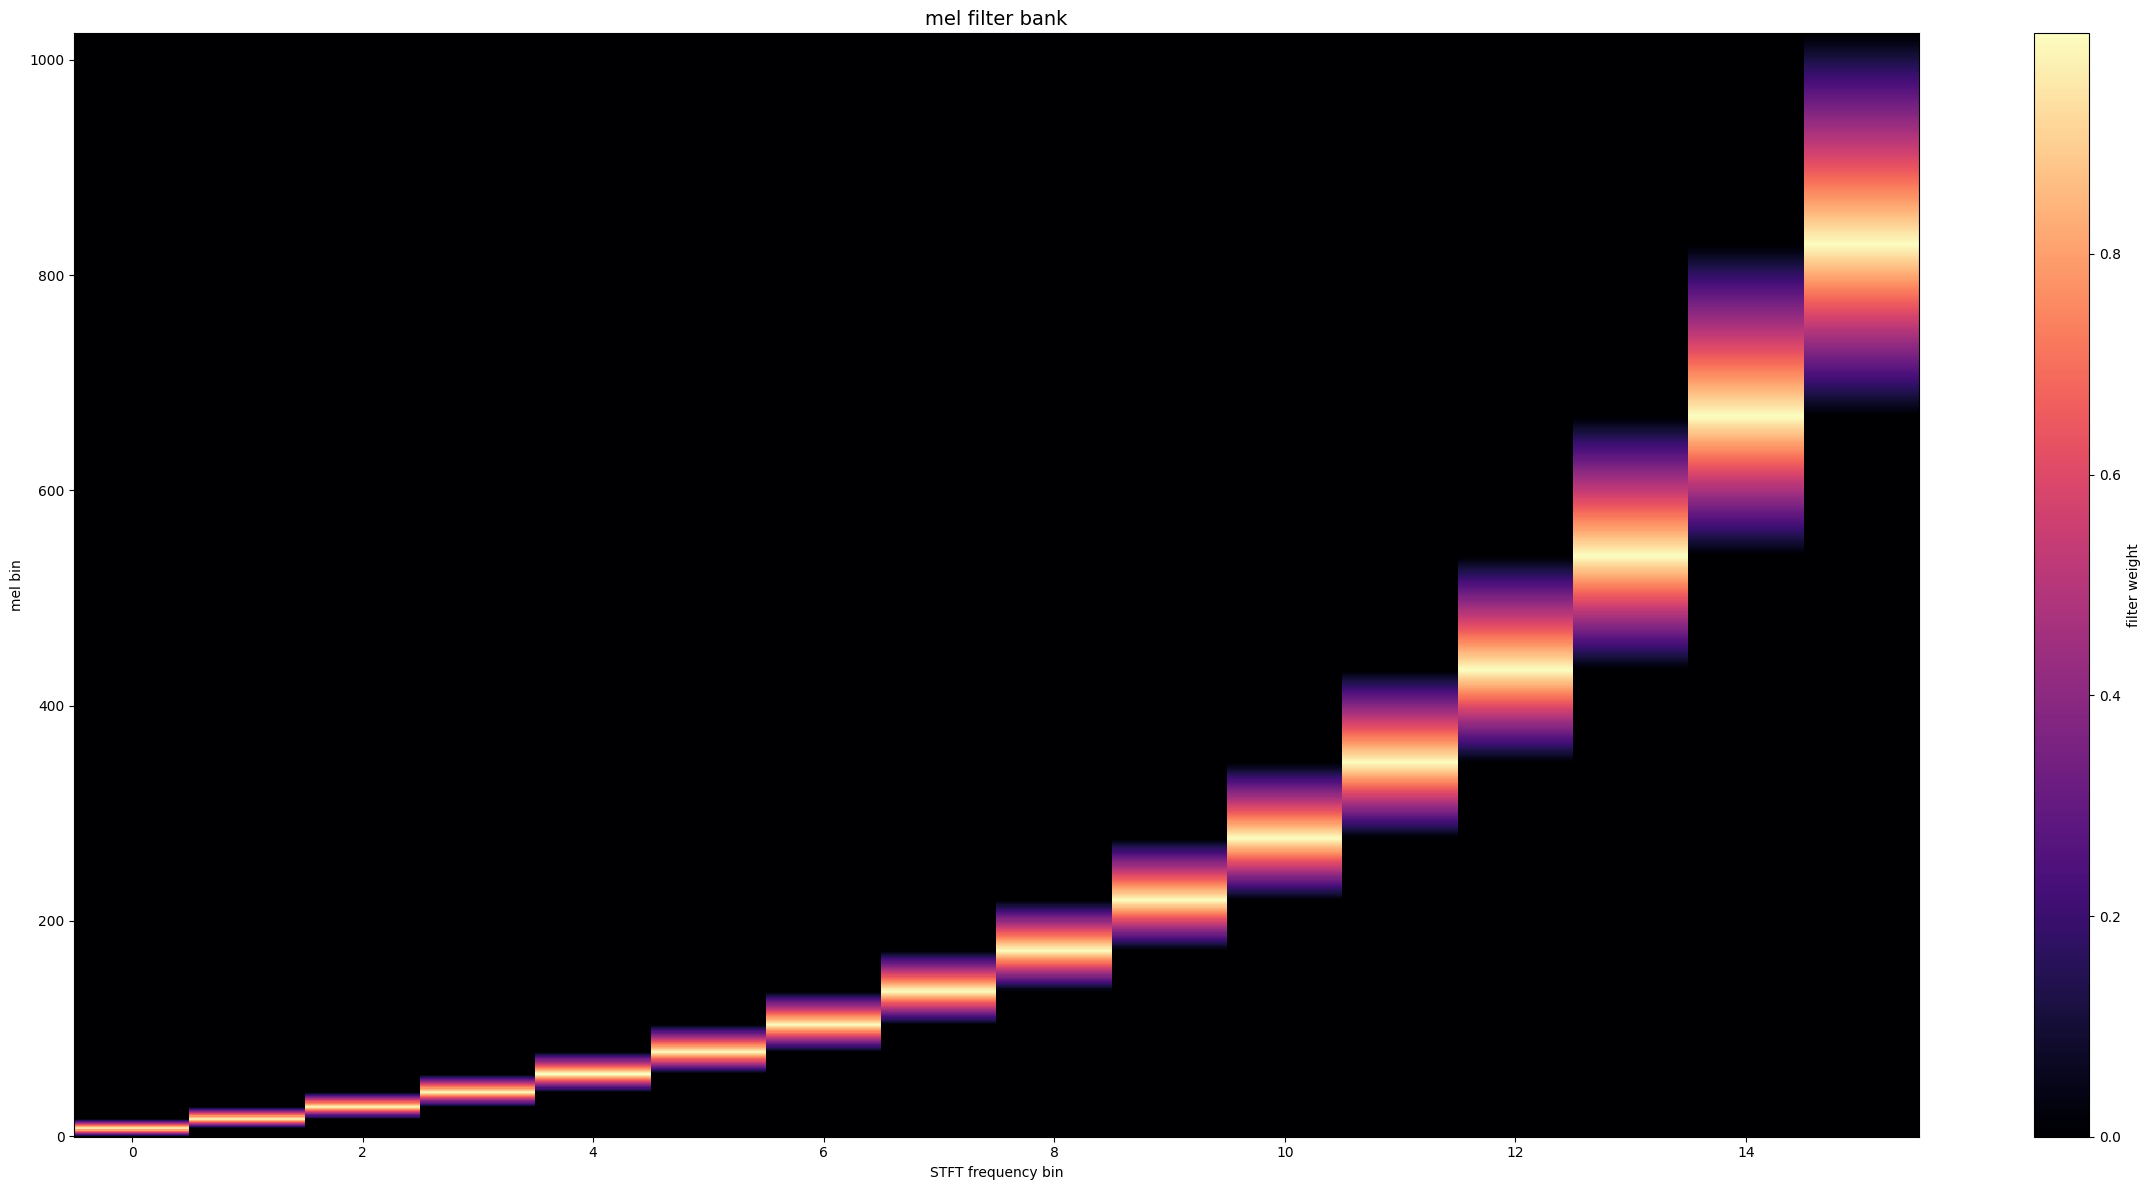

In [112]:
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=2048,
    hop_length=512,
    n_mels=16, # for easy interpretation
    f_min=0.0,
    f_max=sr // 2,
    power=2.0
)

mel_filter_bank = mel_transform.mel_scale.fb

plt.figure(figsize=(24, 12))
plt.imshow(
    mel_filter_bank.numpy(),
    aspect='auto',
    origin='lower',
    cmap='magma',
    interpolation='nearest'
)
plt.title("mel filter bank", fontsize=14)
plt.xlabel("STFT frequency bin")
plt.ylabel("mel bin")
plt.colorbar(label="filter weight")
plt.tight_layout()
plt.show()


## Mel spectrogram

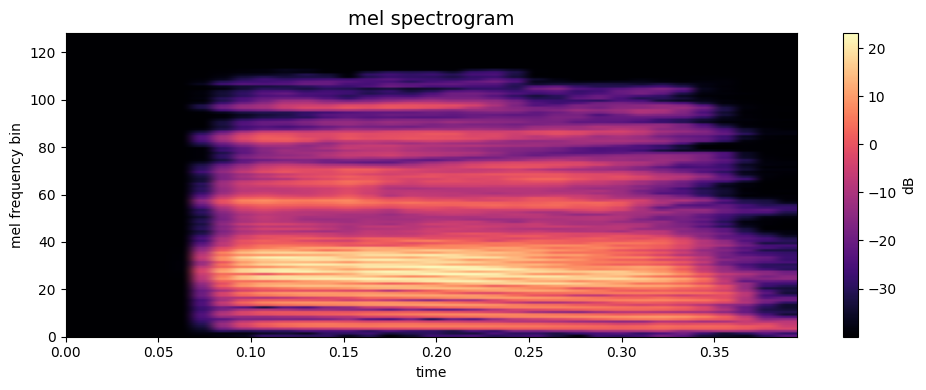

In [115]:
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=2048,
    hop_length=512,
    n_mels=128,
    f_min=0.0,
    f_max=sr // 2,
    power=2.0
)
mel_spec = mel_transform(phoneme)

mel_spec_db = 10 * torch.log10(mel_spec + 1e-4)

plt.figure(figsize=(10, 4))
plt.imshow(
    mel_spec_db.numpy(),
    origin='lower',
    aspect='auto',
    cmap='magma',
    extent=[0, phoneme.size(0)/sr, 0, 128]
)

plt.title("mel spectrogram", fontsize=14)
plt.xlabel("time")
plt.ylabel("mel frequency bin")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()
